# Исследование успешности игр

**Задача:**

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные компании.

**Данные:**

Из открытых источников взяты исторические данные о продажах игр, оценки пользователей и критиков, жанры и платформы (например, Xbox или PlayStation).

> В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Изучение общей информации о данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df_game = pd.read_csv('games.csv')

In [3]:
df_game.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Описание данных**
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB

**Вывод:**

Есть довольно большое кол-во пропусков. `Year_of_Release` - имеет формат float, а должен быть int, `User_Score` - имеет тип object, а должен быть float, `Critic_Score` - имеет формат float, а должен быть int, необходимо будет изменить типы этих столбцов.

### Подготовка данных

#### Изменение названий столбцов

Перед началом подготовки данных для дальнейшей работы, приведем названия столбцов к нижнему регистру.

In [5]:
df_game.columns = df_game.columns.str.lower()

In [6]:
df_game.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Изменение типов данных

Как было замечено выше, в 3 столбцах неправильно указаны типы данных. Заменим их на подходящие.

In [7]:
df_game['year_of_release'] = df_game['year_of_release'].astype('Int64')
df_game['critic_score'] = df_game['critic_score'].astype('Int64')

In [8]:
df_game['user_score'] = pd.to_numeric(df_game['user_score'], errors='coerce')

#### Обработка пропусков

In [9]:
df_game.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Для начала проверим пропуски в столбцах `name` и `genre`. Их всего два и, скорее всего, их можно будет убрать и на дальнейший анализ это не повлияет.

In [10]:
df_game[df_game['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


In [11]:
df_game = df_game[df_game['name'].isna() == False]

TBD в столбце `user_score` - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Это значит, что слишком мало оценок или их нет вообще для формирования рейтинга. Заменим значение "tbd" - "to be determined" на NaN

In [12]:
df_game['user_score'] = df_game['user_score'].replace('tbd', 'NaN')

В столбце `rating` заменим пропущенные значения на "undefiend".

In [13]:
df_game['rating'] = df_game['rating'].fillna('undefined')

#### Подсчет суммарных продаж по всем регионам

In [14]:
df_game['world_sales'] = df_game['na_sales'] + df_game['eu_sales'] + df_game['jp_sales'] + df_game['other_sales']

**Вывод:**

Подготовка данных завершена. 

Пропуски могли возникнуть в первую очередь из-за технических проблем или недостатком первоначальной информации, к примеру в данных присутствует 2 строки с играми 1993 года, без названия, жанра и оценок с очень малыми продажами. Для дальнейшей работы эти строки были удалены.

Пропуски в столбцах `user_score` и `critic_score` могут быть из-за недостатка оценок игроков и критиков (для такого недостатка оценок в столбце `user_score` использовалась аббревиатура tbd). Пропуски в этих столбцах было решено оставить, так как данных, которые так или иначе могли повлиять на примерное заполнение пропусков в данной таблице нет.

Пропуски в столбце `rating` могут присутствовать из-за системы рейтинга ESRB, использующегося в основном для игр, созданных в Северной Америке и Европе. Здесь пропуски так же остались, ведь не все игры могли прошли рейтинг ESRB.

Пропуски в столбце `year_of_release` может быть технической ошибкой, и так же в таблице нет информации для примерного заполнения данного столбца.


Можно приступать к исследовательской части анализа данных.

### Исследовательский анализ данных

Теперь необходимо провести исследования и ответить на следующие вопросы:
- Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Как менялись продажи по платформам. Выбрать платформы с наибольшими суммарными продажами и построить распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Необходимо взять данные за соответствующий актуальный период. Эти данные помогут построить прогноз на 2017 год.
- Какие платформы лидируют по продажам, растут или падают? Выбрать несколько потенциально прибыльных платформ.
- Построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Описать результат.
- Посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построить диаграмму рассеяния и посчитать корреляцию между отзывами и продажами Сформулировать выводы. Соотнести выводы с продажами игр на других платформах.
- Посмотреть на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

#### Выпуск игр по годам

Посмотрим, сколько игр выпускалось в разные годы.

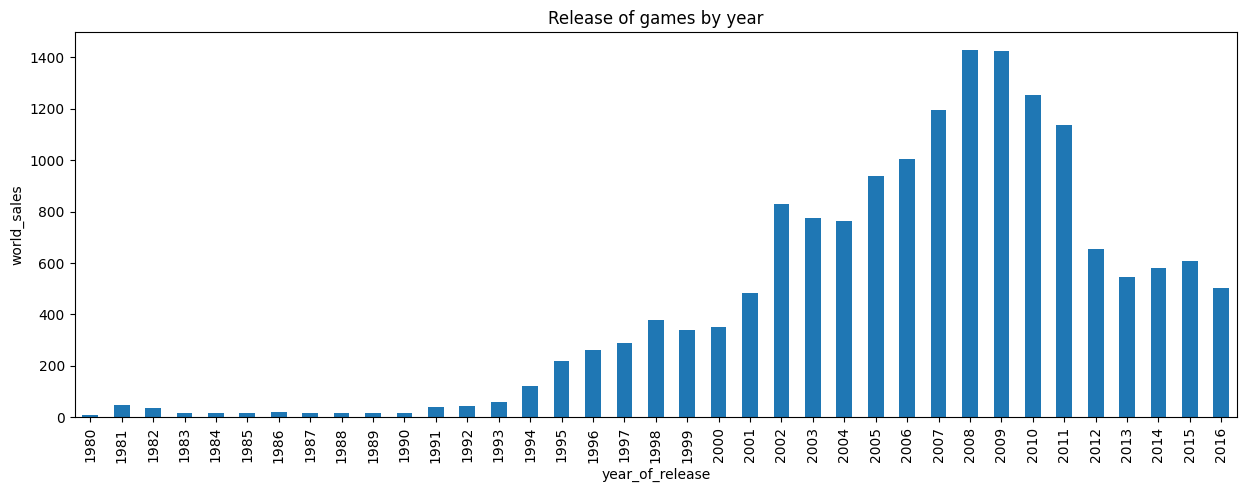

In [15]:
(
    df_game
    .groupby('year_of_release')['name']
    .count()
    .plot(x=df_game['year_of_release'], y='name', kind='bar', figsize=(15,5), title='Release of games by year', ylabel='world_sales')
);

На графике видно, что до 1994 года количество игр было совсем малым. Это может быть связано с тем, что компьютерные технологии только начинали проникать в жизнь обычных людей, только начинали создаваться команды, которые производили игры, и консоли, предназначенные для игр. В 1994 году вышла первая игра для приставки Sony PlayStation, которая изменила игровую индустрию. Это привело к созданию многочисленных новых игровых проектов, а также большему количеству игроков.

Резкий скачок по количеству игр, произошел в 2002 году.

Пик - 2008-2009 года. В 2009 году игровая индустрия пострадала от глобального экономического кризиса. Кризис привел к снижению потребительского спроса, что в свою очередь привело к снижению продаж игр. Также в 2009 году началось распространение пиратских копий игр, что также привело к снижению продаж.

#### Продажи по платформам

Посмотрим на то, сколько игр выпускалось на каждую платформу за весь анализируемый период.

In [16]:
platform_sales = df_game.groupby('platform')['world_sales'].sum()
platform_sales = platform_sales.sort_values(ascending=True)

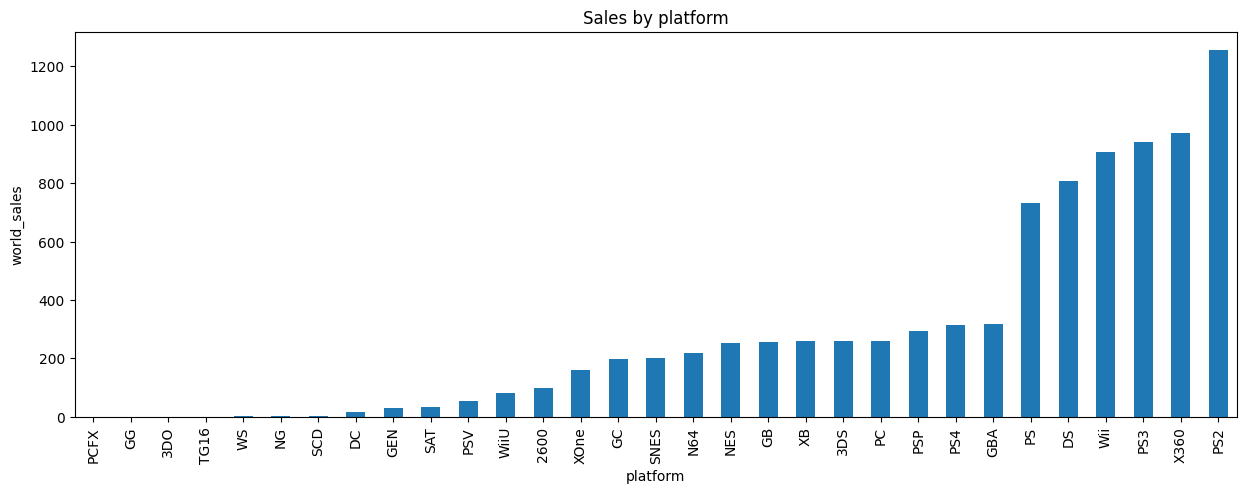

In [17]:
platform_sales.plot(x=df_game['platform'], y='world_sales', kind='bar', figsize=(15,5), title='Sales by platform', ylabel='world_sales');

По статистике до 2016 года лидером является платформа PS2. Далее идут Xbox360, PS3, Wii, DS и PS.

In [18]:
def platforms_leaders(df):
    global platform_leaders
    platform_leaders = list(df.groupby('platform')['world_sales'].sum().sort_values()[-6:].index)
    global unique_years
    unique_years = list(df['year_of_release'].sort_values().unique())
    global table_platform
    table_platform = pd.DataFrame(columns=['platform', 'year'])
    data = []
    for a in platform_leaders:
        for b in unique_years:
            table_platform = table_platform.append({'platform':a,'year':b}, ignore_index=True)       
    for i in platform_leaders:
        for j in unique_years:
            data.append(
                sum(df.loc[(df['platform'] == i) & \
                           (df['year_of_release'] == j), 'world_sales'])
                       )
    

    table_platform['sum_of_year'] = data



df_game_after_1994 = df_game[df_game['year_of_release'] >= 1994]

platforms_leaders(df_game_after_1994)


for i in platform_leaders:
    period_platform = table_platform[table_platform['platform'] == i]
    period_platform = period_platform[period_platform['sum_of_year'] >= 1]
    year_min = period_platform['year'].min()
    year_max = period_platform['year'].max()
    print(f'{i} {year_min} - {year_max} ({year_max-year_min} лет)')

PS 1994 - 2003 (9 лет)
DS 2004 - 2013 (9 лет)
Wii 2006 - 2015 (9 лет)
PS3 2006 - 2016 (10 лет)
X360 2005 - 2016 (11 лет)
PS2 2000 - 2010 (10 лет)


Можно заметить, что каждая из платформ "прожила" примерно по 10 лет.

В среднем платформы живут 10 лет, потому что производители хотят держать игроков в игре, постоянно предлагая им новые игры и обновления. Кроме того, с течением времени в игровых консолях появляются новые технологии и возможности, которые привлекают игроков.

#### Актуальный период для построения прогноза

Необходимо выбрать актуальный период за который будем оценивать данные для прогноза на 2017 год. Многие новые платформы, появляются в 2006 году (например: Wii, PS3, X360), их характерный срок жизни примерно 10 лет, но к 2013 году идет активный спад этих платформ из-за выхода новых и актуальных на нынешнее время платформ. Таким образом актуальные данные можно считать с 2013 года.

In [19]:
df_game = df_game[df_game['year_of_release'] >= 2013]

#### Потенциально прибыльные платформы

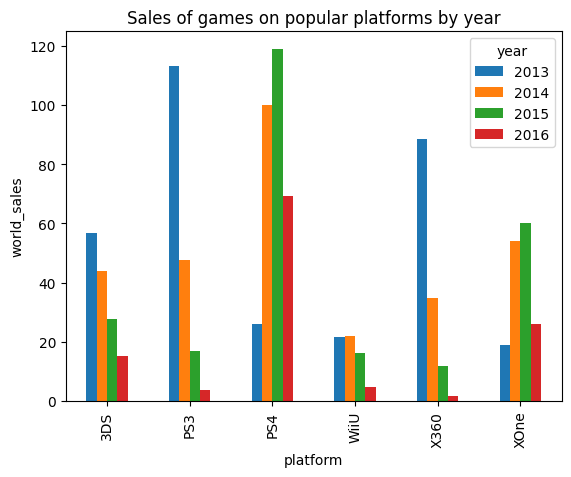

In [20]:
platforms_leaders(df_game)
(
    table_platform
    .pivot_table(index='platform', columns='year', values='sum_of_year')
    .plot(kind='bar', legend=True , title='Sales of games on popular platforms by year', ylabel='world_sales')
);

Как видно из графика, к декабрю 2016 года самыми популярными платформами являются PS4, XOne и 3DS. Так же прослеживается общая тенденция снижения продаж, особенно у платформ "старого" поколения.

#### Глобальные продажи игр по платформам

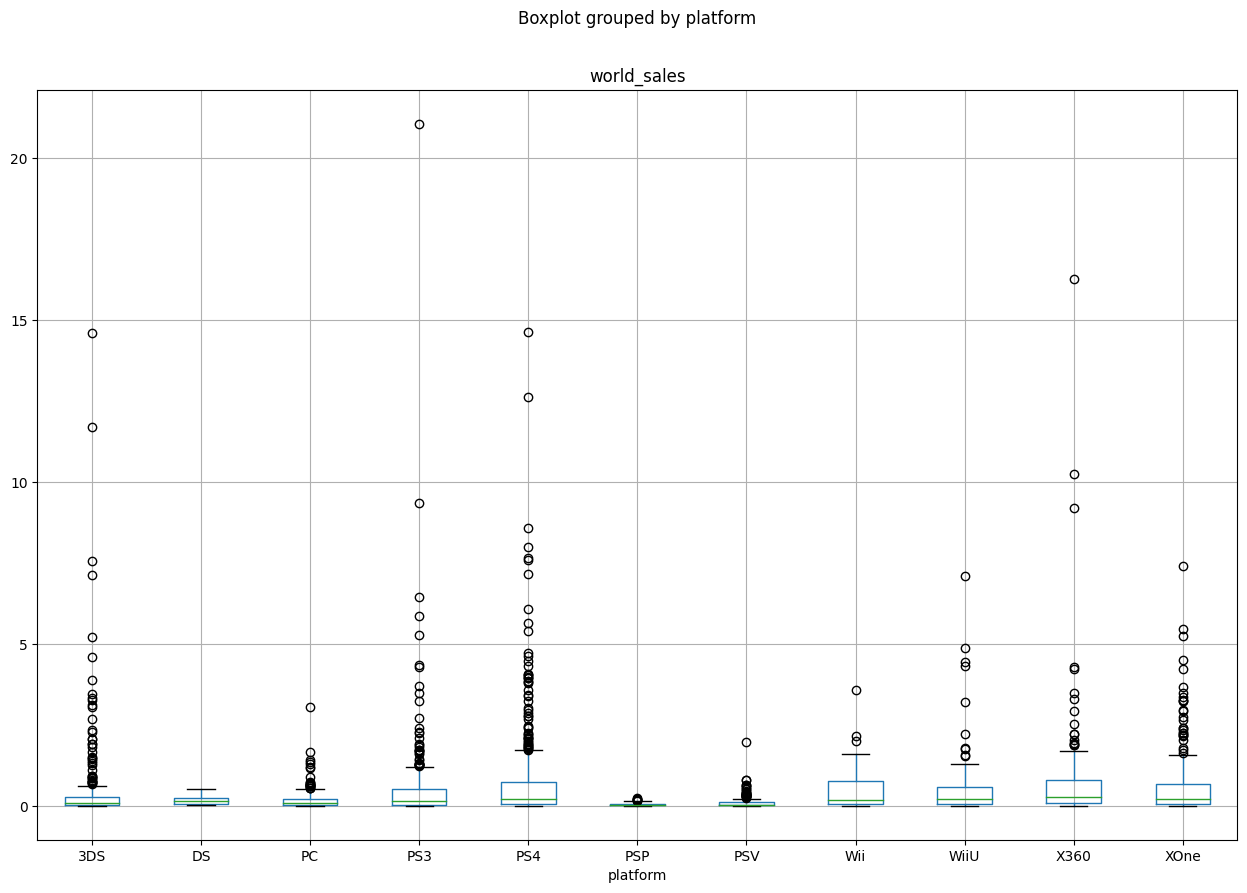

In [21]:
df_game.boxplot(column='world_sales',by='platform', figsize=(15,10) );

Самые большие выбросы у платформ PS3 и X360, так как они были намного популярнее своих конкурентов и новые платформы еще не успели догнать их по продажам. Но так же у значительного большинства платформ присутствуют выбросы, что может говорить о популярности тех или иных игр. Компьютерные игры (PC) стоят дешевле консольных и приставки все-таки больше приспособлены для игр.

Рассмотрим график более внимательно.

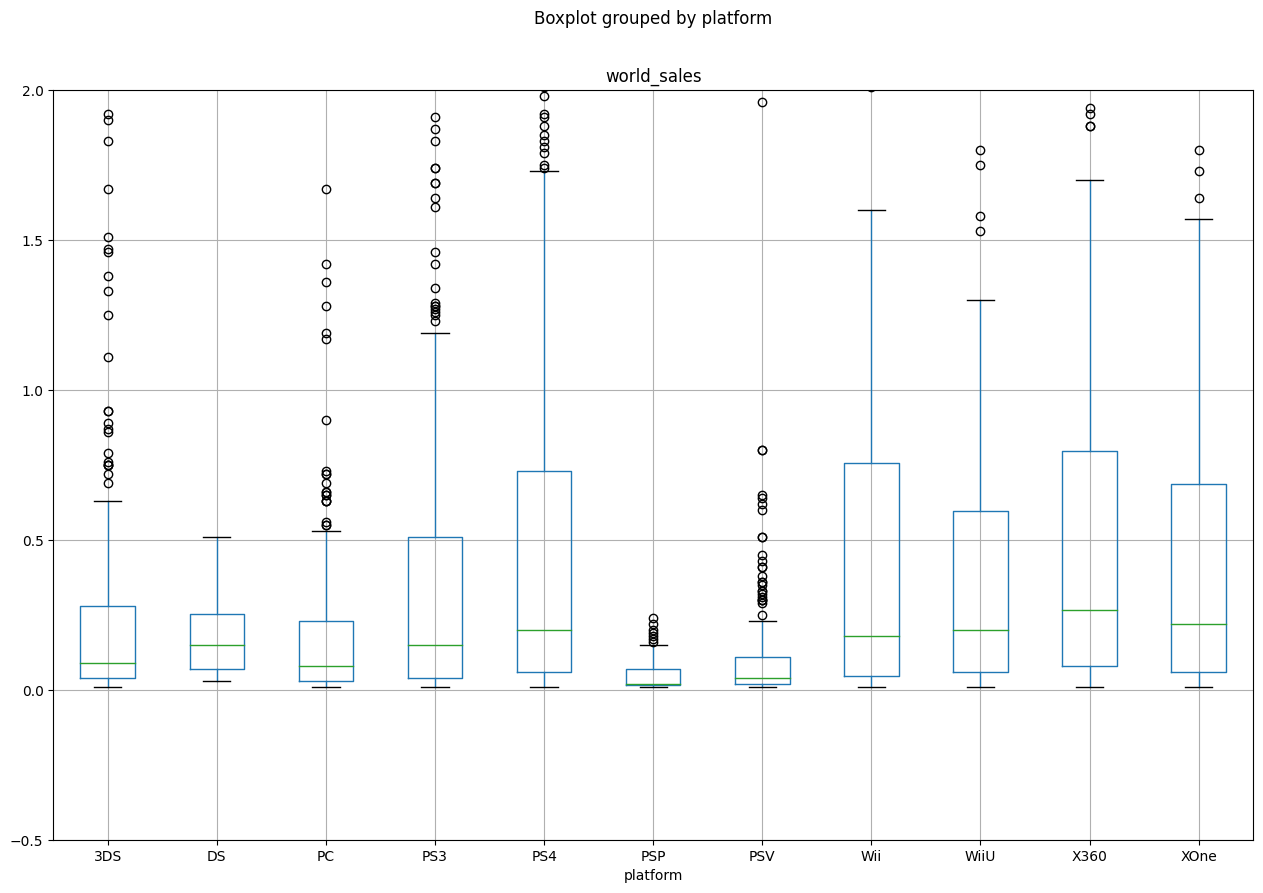

In [22]:
df_game.boxplot(column='world_sales',by='platform', figsize=(15,10) );
plt.ylim(-0.5,2);

На графике видно, что наибольшие медианные продажи у X360, но эта платформа не сильно отрывается от остальных популярных платформ. 

#### Влияние отзывов на продажи

Рассмотрим как влияют на продажи игр на PS4 отзывы пользователей и критиков. 

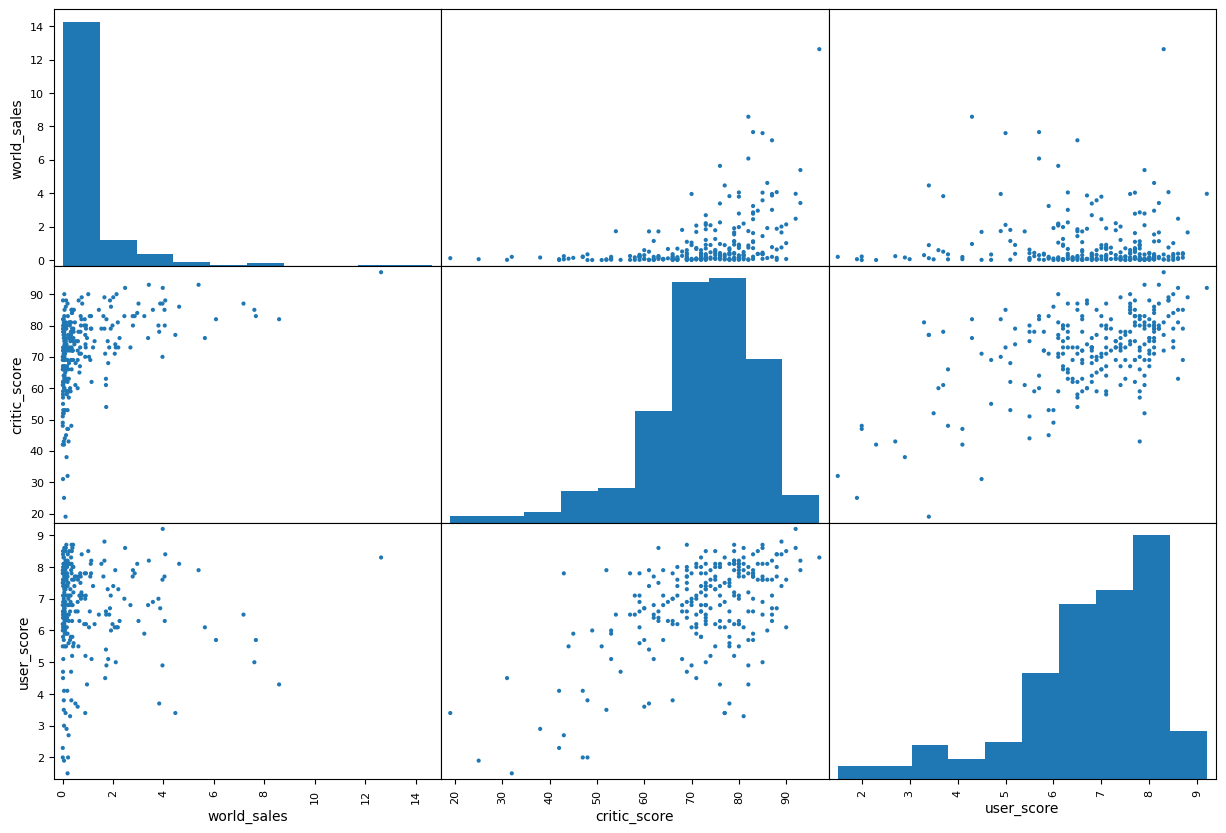

In [23]:
PS4_df = df_game.loc[df_game['platform'] == 'PS4', ['world_sales', 'critic_score', 'user_score']]
pd.plotting.scatter_matrix(PS4_df, figsize=(15,10), alpha=1);

In [24]:
PS4_df.corr()

,world_sales,critic_score,user_score
world_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


В целом видна закономерность, чем больше рейтинг, тем больше продаж, но есть и "аномалии" - в столбце `user_score` есть игры, которые имеют среднюю оценку пользователей, но при этом лучше продались, чем игры с более высокими оценками.

Так же рассмотрим влияние оценок на продажи на платформах XOne и 3DS, которые занимают второе и третье место по популярности, соответственно.

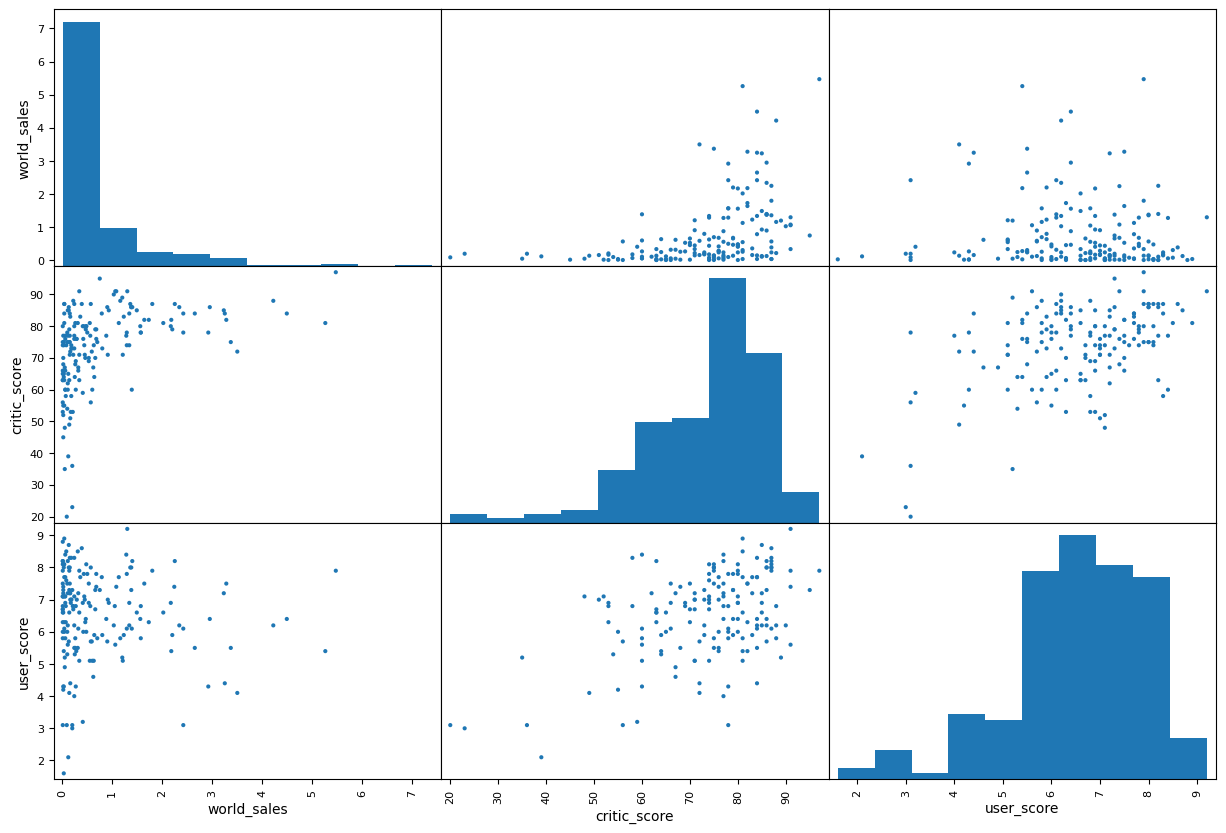

In [25]:
XOne_df = df_game.loc[df_game['platform'] == 'XOne', ['world_sales', 'critic_score', 'user_score']]
pd.plotting.scatter_matrix(XOne_df, figsize=(15,10), alpha=1);

In [26]:
XOne_df.corr()

,world_sales,critic_score,user_score
world_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


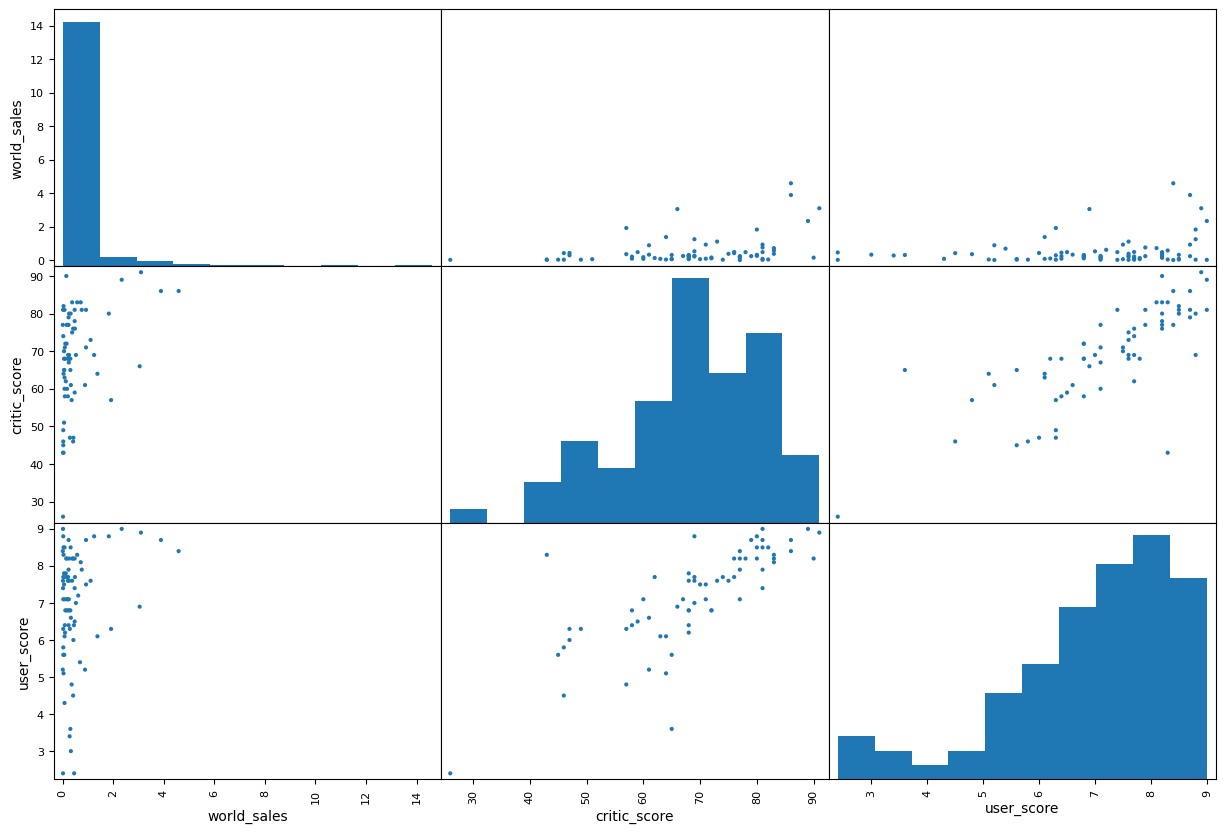

In [27]:
DS_3_df = df_game.loc[df_game['platform'] == '3DS', ['world_sales', 'critic_score', 'user_score']]
pd.plotting.scatter_matrix(DS_3_df, figsize=(15,10), alpha=1);

In [28]:
DS_3_df.corr()

,world_sales,critic_score,user_score
world_sales,1.000000,0.357057,0.241504
critic_score,0.357057,1.000000,0.769536
user_score,0.241504,0.769536,1.000000


Как видно из диаграмм рассеивания и корреляции, на XOne и 3DS влияние оценок на продажи не сильно отличается.

#### Распределение продаж игр по жанрам

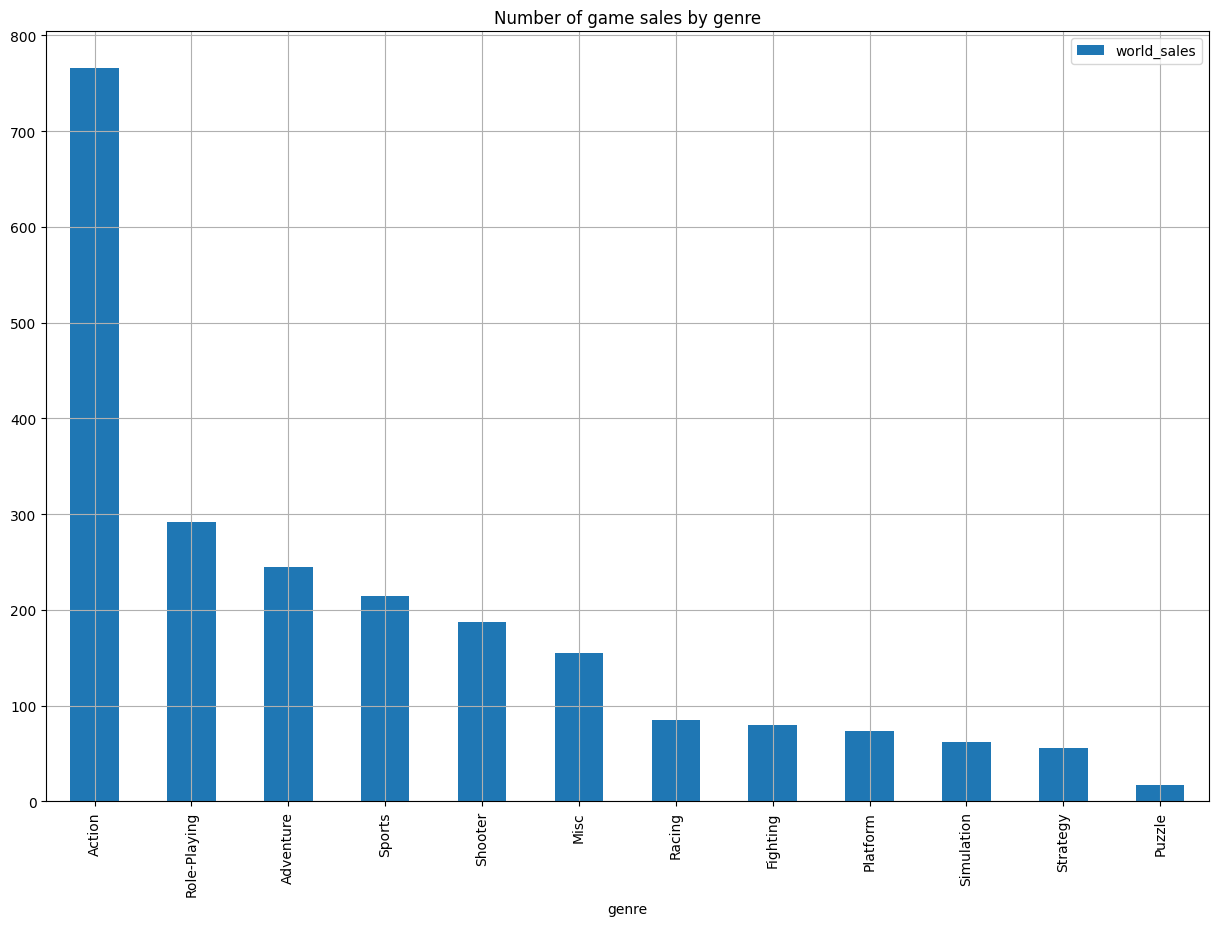

In [29]:
(
    df_game
    .pivot_table(index='genre', values='world_sales', aggfunc='count')
    .sort_values(by='world_sales', ascending=False)
    .reset_index()
    .rename_axis(None, axis=1)
    .plot(x='genre', y='world_sales', kind='bar', figsize=(15,10), title='Number of game sales by genre', grid=True)
);

Больше всего продано игр в жанрах Action, Role-Playing и Adventure. Данные жанры имеют огромную популярность среди игроков. Action и Role-Playing игры предлагают игрокам большое количество возможностей для интерактивного исследования и приключения. В Adventure играх игроки могут просматривать прекрасные локации, получать новую информацию и решать сложные головоломки. Эти жанры предоставляют игрокам много возможностей для увлекательной игры.

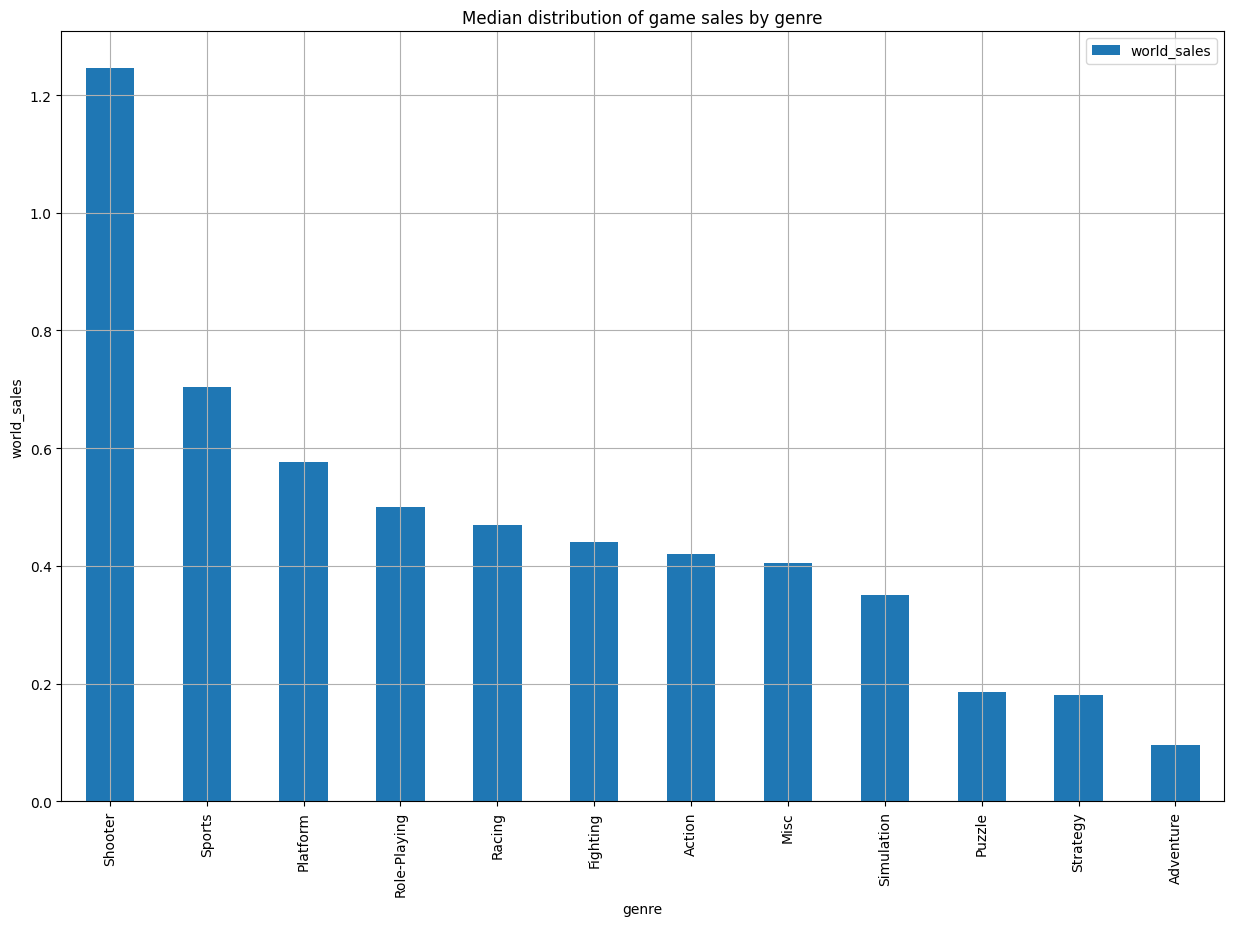

In [30]:
(
    df_game
    .pivot_table(index='genre', values='world_sales', aggfunc='mean')
    .sort_values(by='world_sales', ascending=False)
    .reset_index()
    .rename_axis(None, axis=1)
    .plot(x='genre', y='world_sales',
          kind='bar', figsize=(15,10),
          title='Median distribution of game sales by genre', grid=True,
          ylabel='world_sales')
);

По медианным продажам же лидирует Shooter. Этот жанр привлекает игроков разнообразием вариантов игры, а также многочисленными дополнительными режимами и игры для повышения интереса.

Однако на втором и третьем месте появились жанры Sports и Platform. Игры в этих жанрах часто имеют уникальные и интересные механики, которые могут привлечь игроков. Например, в играх в жанре Sports игроки могут конкурировать с другими игроками в игре, а в играх в жанре Platform игроки могут исследовать игровые миры и преодолевать различные препятствия. Также многие игры имеют возможность игры в онлайн-режиме, которая привлекает больше игроков.


Жанр Action является одним из популярных жанров, но по больше дохода приносят игры в жанре Shooter.

А жанр с самыми низкими продажами является Adventure. Такие игры, обычно требуют больше времени для игры и больше интеллектуальных навыков, чем игры в других жанрах. Они также более сложны и менее понятны, что может отпугнуть некоторых игроков. Также многие игроки предпочитают более активные игры, которые предлагают больше действий и больше возможностей для победы.

**Вывод:** 

Исследовательский анализ данных завершен. На все вышепоставленные вопросы было отвечено и можно переходить к составлению портрета пользователя для каждого региона.

### Портрет пользователя каждого региона

In [31]:
def top_platform_in_region(data, group_col, region_sales):
    region_plot = data.groupby(group_col)[region_sales].sum().sort_values(ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': 'forestgreen', 'eu_sales': 'blue', 'jp_sales': 'red'}
    region_plot.plot(kind='bar', title=title_dict[region_sales],
                     color=color_dict[region_sales], grid=True, rot=20,
                     ylabel='world_sales')

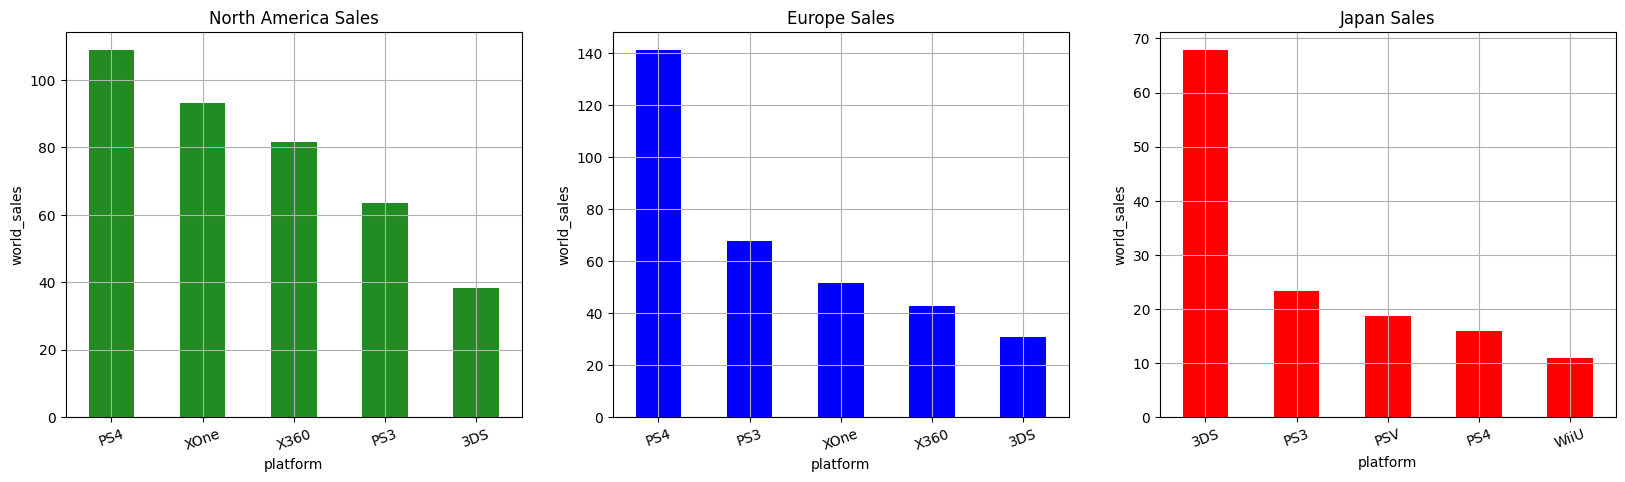

In [32]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
top_platform_in_region(df_game, 'platform', 'na_sales')
plt.subplot(132)
top_platform_in_region(df_game, 'platform', 'eu_sales')
plt.subplot(133)
top_platform_in_region(df_game, 'platform', 'jp_sales')
plt.show()

В Северной Америке пользуются популярностью XOne и X360, уступая лишь PS4. Дальше идут PS3 и 3DS.

В Европе же PS4 так же лидирует, ну а после нее идет PS3, обгоняя более популярные в Северной Америке XOne и X360. Закрывает пятерку так же, как и в Северной Америке, 3DS.

В Японии же складывается совсем иная ситуация. 3DS лидирует, а из платформ из нового поколения только PS4, которое занимает четвертое место в регионе.

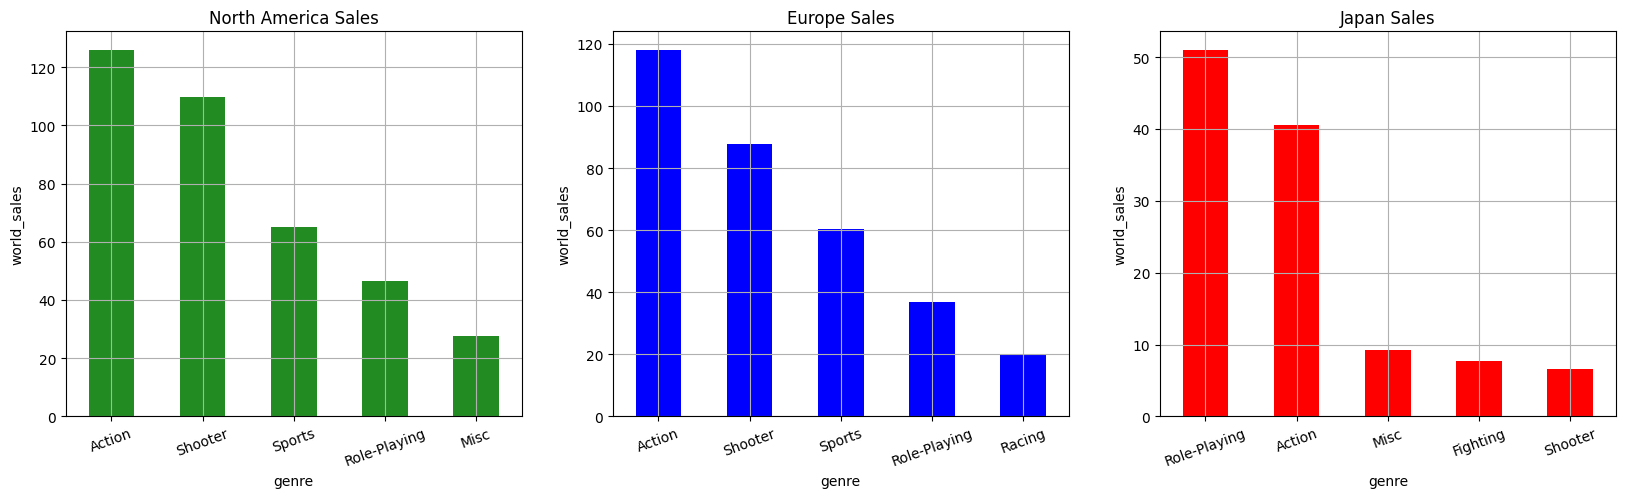

In [33]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
top_platform_in_region(df_game, 'genre', 'na_sales')
plt.subplot(132)
top_platform_in_region(df_game, 'genre', 'eu_sales')
plt.subplot(133)
top_platform_in_region(df_game, 'genre', 'jp_sales')
plt.show()

По популярности жанров Северная Америка и Европа похожи. Экшен, шутер, спортивные игры и ролевые игры. Однако на пятом месте в Европе расположились гонки, когда у Северной Америки разножанровые игры.

Так же как и с платформами, в Японии больше предпочитают ролевые игры, а уже потом экшены. и эти два жанра идут с большим отрывом, по сравнению с остальными. 

In [34]:
def ERSB_group_rating(rating):
    if rating == 'M':
        return 'Для взрослых'
    elif rating == 'E':
        return 'Для всех'
    elif rating == 'E10+':
        return 'От 10 лет и старше'
    elif rating == 'T':
        return 'Подросткам'
    elif rating == 'undefined':
        return 'Неопределенно'

In [35]:
df_game['ERSB_rating'] = df_game['rating'].apply(ERSB_group_rating)

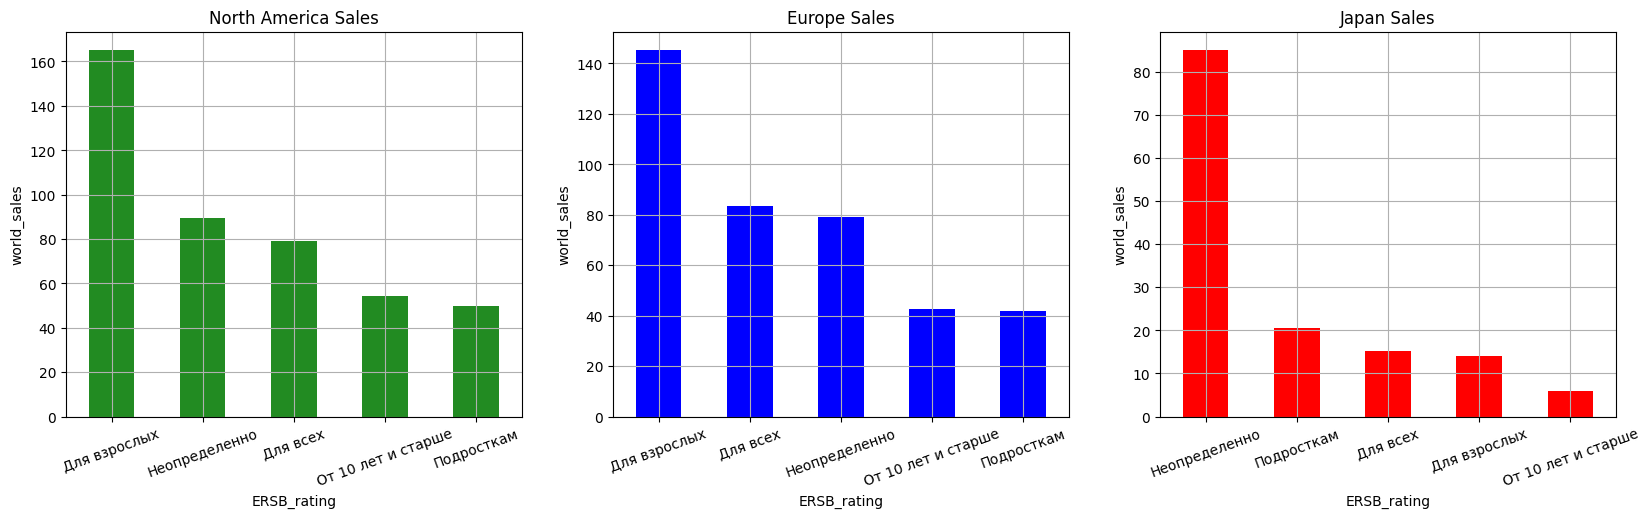

In [36]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
top_platform_in_region(df_game, 'ERSB_rating', 'na_sales')
plt.subplot(132)
top_platform_in_region(df_game, 'ERSB_rating', 'eu_sales')
plt.subplot(133)
top_platform_in_region(df_game, 'ERSB_rating', 'jp_sales')
plt.show()

В Северной Америке и Европе все так же схожие картины. Лидерами продаж являются игры для взрослых. Дальше, не учитывая неопределенный рейтинг, продажи начинают падать, в зависимости от повышения возраста аудитории.

В Японии же значительно большая часть игр без рейтинга, возможно, это связано с тем, что ESRB принадлежит американской компании и возможно не все японские игры подходят для рейтинга.

**Вывод:**

Североамериканские и европейские игроки практически схожи в интересах, играют на практически одинаковых платформах, обожают одни и те же жанры и выбирают игры схожего рейтинга. Что не скажешь о японских игроках, что предпочитают чуть ли не все то, что не популярно в Европе или Северной Америке.

### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Н0 (нулевая гипотеза)** - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Н1 (альтернативная гипотеза)** - средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

In [37]:
sample_1 = list(df_game[df_game['platform'] == 'XOne']['user_score'].dropna())
sample_2 = list(df_game[df_game['platform'] == 'PC']['user_score'].dropna())

alpha = .05

results = st.ttest_ind(sample_1, sample_2, equal_var = True)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

Не получилось отвергнуть нулевую гипотезу.

Верно следующее утверждение: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Средние пользовательские рейтинги платформ Xbox One и PC могут быть одинаковыми по нескольким причинам. Игры для Xbox One и PC могут иметь похожие графические и игровые механики. Так же игры для Xbox One и PC могут получать одинаковую поддержку от издателей и разработчиков игр. Это позволяет им предлагать похожие обновления и дополнения, что привлекает больше игроков и повышает общие пользовательские рейтинги.

#### Средние пользовательские рейтинги жанров Action и Sports разные

**H0 (нулевая гипотеза)** - Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**H1 (альтернативная гипотеза)** - Средние пользовательские рейтинги жанров Action и Sports отличаются между собой.

In [38]:
sample_3 = list(df_game[df_game['genre'] == 'Action']['user_score'].dropna())
sample_4 = list(df_game[df_game['genre'] == 'Sports']['user_score'].dropna())

alpha = .05

results = st.ttest_ind(sample_3, sample_4, equal_var = True)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.0517832389140023e-27
Отвергаем нулевую гипотезу


**Вывод:**

Отвергаем нулевую гипотезу.

Таким образом, остается верным утверждение, что средние пользовательские рейтинги жанров Action и Sports отличаются.

### Общий вывод

Было проведено исследование, по выявлению определяющих успешность игры закономерностей. Результаты исследования позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В ходе исследования были даны ответы на следующие вопросы:

- **Сколько игр выпускалось в разные годы и важны ли данные за все периоды?**

До 1994 года количество игр было совсем малым. Резкий скачок по количеству игр, произошел в 2002 году, а пик на 2008-2009 гг. За годы существования вышло много платформ и игр. Для продолжения исследования был выявлен актуальный период.


- **За какой характерный срок появляются новые и исчезают старые платформы?**

Характерный срок жизни платформы - 10 лет.

- **Необходимо взять данные за соответствующий актуальный период. Основной фактор — эти данные помогут построить прогноз на 2017 год.**

Данные были взяты с 2013 по 2016 года, за несколько лет до появления новых платформ, чья популярность растет с каждым годом.

- **Какие платформы лидируют по продажам, растут или падают?**

Потенциально прибыльные платформы - PS4, XOne, 3DS. Это новые платформы, и они растут. За ними идут платформы "старого" поколения, продажи которых с каждым годом становиться все ниже и ниже.

- **Описать результат по глобальным продажам игр в разбивке по платформам.**

Почти у всех платформ есть определенные игры, которые "выстрелили". Компьютерные игры PC стоят дешевле консольных.

- **Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков?**

В целом присутствует закономерность, чем больше рейтинг, тем больше продаж.


- **Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

Больше всего продано игр в жанрах Action, Role-Playing и Adventure. Данные жанры имеют огромную популярность среди игроков. 

Жанр Shooter является одним из популярных жанров с большими продажами по ряду причин. А жанр с самыми низкими продажами является Adventure, так как в такие игры более сложны и менее понятны, что может отпугнуть некоторых игроков.

Так же были составлены **портреты пользователей каждого региона**. В Северной Америке самая популярная платформа X360. Европейцы предпочитают PS3. В Японии популярны DS.

В Северной Америке и Европе самые популярные жанры практически совпадают. В Японии вкусы отличаются.

В Европе и Северной Америке лидерами продаж являются игры для взрослых. А дальше, продажи начинают падать, в зависимости от повышения возраста аудитории. В Японии опять не так. Первое место такое же - "Подросткам", а вот на втором - игры для всех, далее 17+.


И в конце были проверены следующие **гипотезы**:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. **Не получилось отвергнуть нулевую гипотезу**.
2. Средние пользовательские рейтинги жанров Action и Sports разные. **Нулевая гипотеза была отвергнута**.